# Proyecto 03 - Panorama
Integrantes:
- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

Repositorio: https://github.com/bl33h/panoramaBuilder

In [50]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt

### 01. Images

In [51]:
def load_images(paths):
    return [cv2.imread(p) for p in paths]

In [52]:
image_paths = ['./img/ours_1.jpg', './img/ours_2.jpg', './img/ours_3.jpg', './img/ours_4.jpg']
images = load_images(image_paths)

### 02. Matching pairs

In [53]:
def detect_and_match(img1, img2):
    orb = cv2.ORB_create(10000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    if des1 is None or des2 is None or len(des1) < 4 or len(des2) < 4:
        print("Warning: Not enough keypoints detected")
        return np.eye(3), None, kp1, kp2, []
    
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    
    matches = sorted(matches, key=lambda x: x.distance)
    
    good_matches = matches[:max(4, int(len(matches) * 0.15))]
    
    if len(good_matches) < 4:
        print(f"Warning: Only {len(good_matches)} good matches found, needed at least 4")
        return np.eye(3), None, kp1, kp2, good_matches
    
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)
    
    if H is None:
        print("Warning: Failed to find homography")
        return np.eye(3), None, kp1, kp2, good_matches
    
    return H, mask, kp1, kp2, good_matches

In [54]:
def build_homographies(images, detect_and_match_fn):
    n = len(images)
    base_idx = n // 2 
    Hs = [None] * n
    Hs[base_idx] = np.eye(3)  
    
    print("Computing homographies for images before reference...")
    for i in range(base_idx - 1, -1, -1):
        print(f"Processing image pair {i+1} -> {i}")
        H, mask, kp1, kp2, matches = detect_and_match_fn(images[i + 1], images[i])
        if H is not None:
            Hs[i] = Hs[i + 1] @ H
        else:
            print(f"Warning: Using identity homography for image {i}")
            Hs[i] = Hs[i + 1]
    
    print("Computing homographies for images after reference...")
    for i in range(base_idx + 1, n):
        print(f"Processing image pair {i-1} -> {i}")
        H, mask, kp1, kp2, matches = detect_and_match_fn(images[i - 1], images[i])
        if H is not None:
            try:
                H_inv = np.linalg.inv(H)
                Hs[i] = Hs[i - 1] @ H_inv
            except np.linalg.LinAlgError:
                print(f"Warning: Matrix inversion failed for image {i}, using identity")
                Hs[i] = Hs[i - 1]
        else:
            print(f"Warning: Using identity homography for image {i}")
            Hs[i] = Hs[i - 1]
    
    return Hs

In [55]:
Hs = build_homographies(images, detect_and_match)
print("Homography matrices calculated successfully!")


Computing homographies for images before reference...
Processing image pair 2 -> 1
Processing image pair 1 -> 0
Processing image pair 1 -> 0
Computing homographies for images after reference...
Processing image pair 2 -> 3
Computing homographies for images after reference...
Processing image pair 2 -> 3
Homography matrices calculated successfully!
Homography matrices calculated successfully!


In [56]:
# mostrar matching pairs
def show_matching_pairs(images):
    for i in range(len(images) - 1):
        img1 = images[i]
        img2 = images[i + 1]

        # Use our enhanced detect_and_match function
        _, _, kp1, kp2, matches = detect_and_match(img1, img2)
        
        # Display at most 50 best matches
        display_matches = matches[:min(50, len(matches))]
        
        # dibujar matches
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, display_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title(f'Matching entre imagen {i+1} y {i+2} - {len(display_matches)} coincidencias')
        plt.axis('off')
        plt.show()

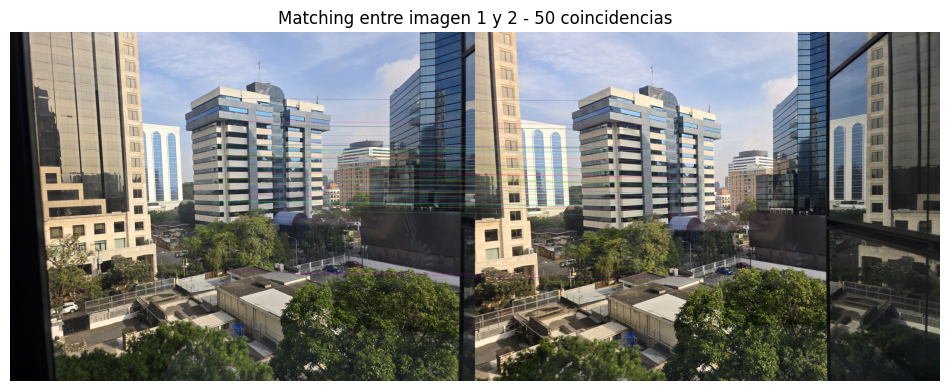

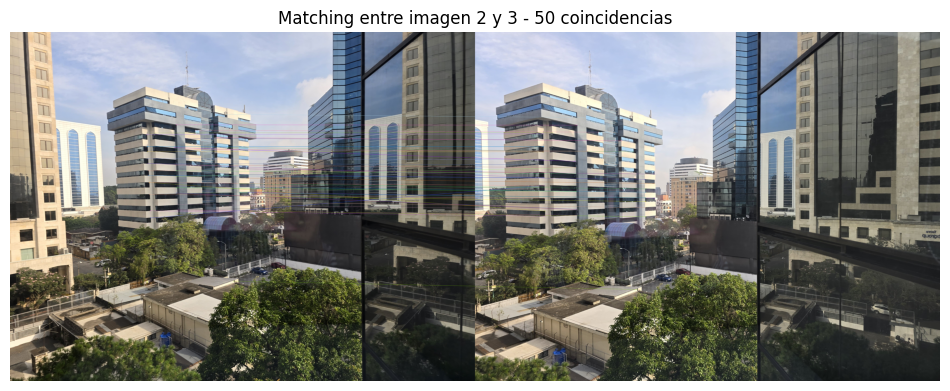

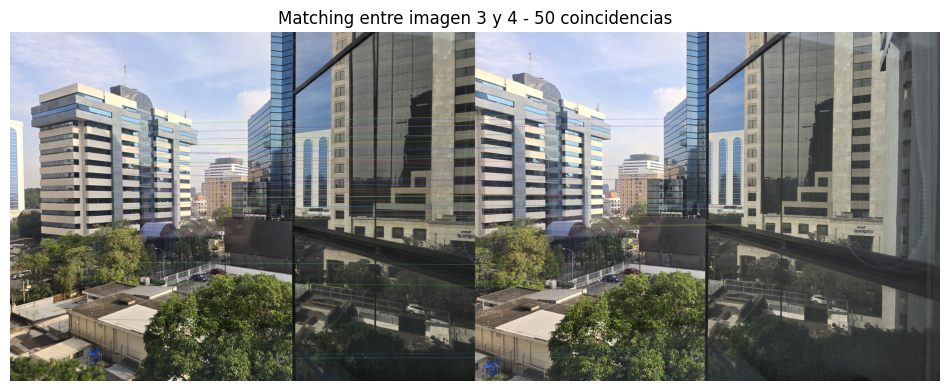

In [57]:
show_matching_pairs(images)

### 03. Wrapping

In [58]:
def warp_images(images, Hs):
    base_img = images[1]
    h, w = base_img.shape[:2]

    all_corners = []
    for i, H in enumerate(Hs):
        img = images[i]
        h_i, w_i = img.shape[:2]
        corners_i = np.array([[0, 0], [0, h_i], [w_i, h_i], [w_i, 0]], dtype=np.float32).reshape(-1,1,2)
        warped_corners = cv2.perspectiveTransform(corners_i, H)
        all_corners.append(warped_corners)

    all_corners = np.concatenate(all_corners, axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    trans = np.array([[1, 0, -xmin],
                      [0, 1, -ymin],
                      [0, 0, 1]])

    warped_imgs = []
    for i, img in enumerate(images):
        H_total = trans @ Hs[i]
        warped = cv2.warpPerspective(img, H_total, (xmax - xmin, ymax - ymin))
        warped_imgs.append(warped)

    return warped_imgs, (xmax - xmin, ymax - ymin)

In [59]:
warped_imgs, size = warp_images(images, Hs)

In [60]:
def show_warped_images_overlay(warped_imgs, canvas_size):
    h, w = canvas_size[1], canvas_size[0]
    canvas = np.zeros((h, w, 3), dtype=np.float32)

    for i, img in enumerate(warped_imgs):
        mask = (img > 0).astype(np.float32)
        canvas += img.astype(np.float32) * 0.5 * mask

    canvas = np.clip(canvas, 0, 255).astype(np.uint8)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title("wrapped images")
    plt.axis("off")
    plt.show()

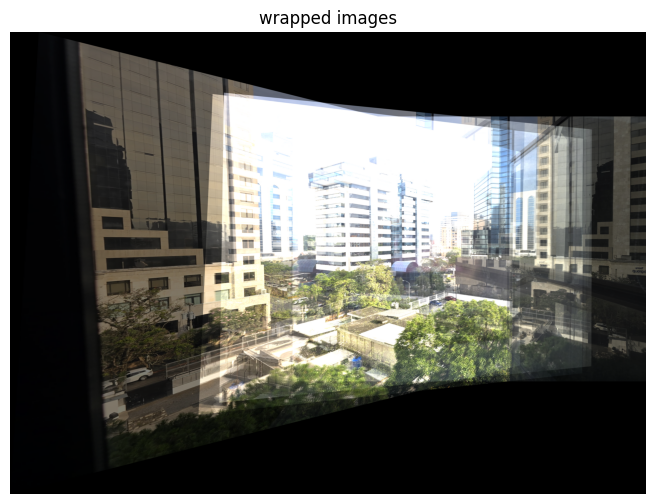

In [61]:
warped_imgs, canvas_size = warp_images(images, Hs)
show_warped_images_overlay(warped_imgs, canvas_size)

### 04. Blending

In [62]:
def blend_images(warped_imgs, size):
    height, width = size[1], size[0]
    panorama = np.zeros((height, width, 3), dtype=np.float32)
    
    weight_masks = []
    for img in warped_imgs:
        mask = (img.sum(axis=2) > 0).astype(np.float32)
        dist = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 5)
        
        if dist.max() > 0:
            dist = dist / dist.max()
            dist = np.power(dist, 2.0)
        
        weight_masks.append(dist)
    
    weight_sum = np.sum(np.array(weight_masks), axis=0)
    weight_sum = np.maximum(weight_sum, 1e-10)
    
    for i, img in enumerate(warped_imgs):
        normalized_weight = weight_masks[i] / weight_sum
        panorama += img.astype(np.float32) * normalized_weight[:, :, np.newaxis]
    
    for c in range(3):
        channel = panorama[:,:,c]
        non_zero = channel[channel > 0]
        if len(non_zero) > 0:
            min_val, max_val = np.percentile(non_zero, [5, 95])
            channel = np.clip(channel, min_val, max_val)
            channel = 255 * (channel - min_val) / (max_val - min_val)
            panorama[:,:,c] = channel
    
    panorama_bgr = np.clip(panorama, 0, 255).astype(np.uint8)
    hsv = cv2.cvtColor(panorama_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,1] = hsv[:,:,1] * 1.2
    hsv[:,:,1] = np.clip(hsv[:,:,1], 0, 255)
    hsv[:,:,2] = hsv[:,:,2] * 1.05
    hsv[:,:,2] = np.clip(hsv[:,:,2], 0, 255)
    panorama_enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    
    return panorama_enhanced

In [63]:
warped_imgs, size = warp_images(images, Hs)
panorama = blend_images(warped_imgs, size)

## Result

In [64]:
def display_image(img, title='Result'):
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

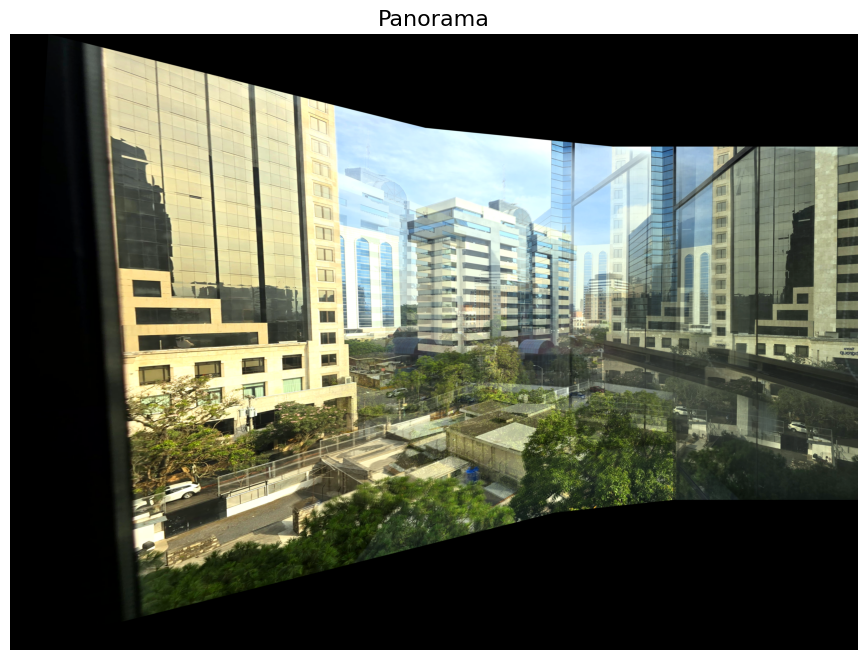

In [65]:

plt.figure(figsize=(14, 8)) 
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Panorama', fontsize=16)
plt.axis('off')
plt.show()